In [1]:
from database.market import Market
from database.sec import SEC
from database.adatabase import ADatabase
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
from statistics import variance
from tqdm import tqdm
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta

In [2]:
market = Market()

In [3]:
market.connect()
prices = market.retrieve("prices")
market.disconnect()

In [6]:
datasets = {}
for strat in ["econ","financial","speculation"]:
    strat_db = ADatabase(f"strategy_{strat}")
    strat_db.connect()
    sim = strat_db.retrieve("sim")
    strat_db.disconnect()
    strat_factors = [x for x in sim.columns if "prediction" in x or "score" in x]
    for factor in strat_factors:
        sim.rename(columns={factor:factor+f"_{strat}"},inplace=True)
    datasets[strat] = sim

In [9]:
financial = datasets["financial"]
econ = datasets["econ"][[x for x in datasets["econ"].columns if "econ" in x or x in ["year","quarter"]]]
speculation = datasets["speculation"]

In [10]:
quarterly_set = financial.merge(econ,on=["year","quarter"],how="left").groupby(["year","quarter","ticker"]).mean().reset_index()

In [11]:
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]

In [12]:
weekly_set = prices.merge(speculation,on=["year","week","ticker"]).dropna()

In [16]:
data = weekly_set.merge(quarterly_set,on=["year","quarter","ticker"]).groupby(["year","week","ticker"]).mean().reset_index()

In [17]:
data

,year,week,ticker,close,high,low,open,volume,adjclose,adjhigh,...,xgb_prediction_financial,xgb_score_financial,cat_prediction_financial,cat_score_financial,skl_prediction_econ,skl_score_econ,xgb_prediction_econ,xgb_score_econ,cat_prediction_econ,cat_score_econ
0,2018,1,A,68.616,68.95600,67.758,67.930,1635981.4,66.729983,67.060067,...,43.854263,0.828260,45.524871,0.892704,283.364489,0.989353,240.851105,0.932185,235.495669,0.975082
1,2018,1,AAL,48.552,49.16376,48.066,48.508,4192834.0,47.384376,47.981625,...,41.409863,0.828260,49.612891,0.892704,283.364489,0.989353,240.851105,0.932185,235.495669,0.975082
2,2018,1,AAPL,170.052,171.01000,168.566,169.440,26819737.8,40.771514,41.001728,...,117.499225,0.828260,132.502256,0.892704,283.364489,0.989353,240.851105,0.932185,235.495669,0.975082
3,2018,1,ABBV,98.208,98.66200,96.586,97.340,4612167.8,81.563551,81.942995,...,74.709951,0.828260,43.965202,0.892704,283.364489,0.989353,240.851105,0.932185,235.495669,0.975082
4,2018,1,ABC,90.466,90.86800,88.917,89.610,1264813.4,84.698228,85.075724,...,60.163467,0.828260,68.896526,0.892704,283.364489,0.989353,240.851105,0.932185,235.495669,0.975082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59541,2021,52,WYNN,87.020,88.24500,86.025,87.280,1987899.5,87.020000,88.245000,...,219.274872,0.888794,245.583279,0.809253,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868
59542,2021,52,XEL,67.220,67.28250,66.600,66.820,1212708.0,67.220000,67.282500,...,129.673843,0.888794,70.864098,0.809253,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868
59543,2021,52,XLNX,221.525,223.83500,217.025,220.390,2879817.5,221.525000,223.835000,...,85.066063,0.888794,100.311842,0.809253,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868
59544,2021,52,XRAY,56.124,56.56200,55.763,56.045,969413.0,56.101867,56.539777,...,59.909763,0.888794,65.800066,0.809253,489.751001,0.961143,334.148285,0.922918,247.196367,0.914868


In [19]:
final = []
for ticker in tqdm(data["ticker"].unique()):
    ticker_data = data[data["ticker"]==ticker]
    ticker_data["y"] = ticker_data["adjclose"].shift(-1)
    final.append(ticker_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:01<00:00, 267.03it/s]


In [21]:
stuff = pd.concat(final)

In [23]:
training_set = stuff[stuff["year"]<2020]
prediction_set = stuff[stuff["year"]>=2020]

In [24]:
factors = [x for x in training_set.columns if x == "adjclose" or "prediction" in x or "score" in x]
factors

['adjclose',
 'skl_prediction_speculation',
 'skl_score_speculation',
 'xgb_prediction_speculation',
 'xgb_score_speculation',
 'cat_prediction_speculation',
 'cat_score_speculation',
 'skl_prediction_financial',
 'skl_score_financial',
 'xgb_prediction_financial',
 'xgb_score_financial',
 'cat_prediction_financial',
 'cat_score_financial',
 'skl_prediction_econ',
 'skl_score_econ',
 'xgb_prediction_econ',
 'xgb_score_econ',
 'cat_prediction_econ',
 'cat_score_econ']

In [25]:
refined_data = {"X":training_set[factors],"y":training_set[["y"]]}
models = m.regression(refined_data)

In [26]:
models

,api,model,score,model_type
0,skl,LinearRegression(),0.998262,regression
1,xgb,"XGBRegressor(base_score=0.5, booster='dart', c...",0.999125,regression
2,cat,<catboost.core.CatBoostRegressor object at 0x0...,0.997949,regression


In [27]:
for row in models.iterrows():
    try:
        model = row[1]["model"]
        api = row[1]["api"]
        score = row[1]["score"]
        prediction_set[f"{api}_prediction"] = model.predict(prediction_set[factors])
        prediction_set[f"{api}_score"] = score
    except:
        print(training_set.index.size)
        continue

In [29]:
prediction_set["prediction"] = (prediction_set["skl_prediction"] + prediction_set["xgb_prediction"] + prediction_set["cat_prediction"]) / 3

In [31]:
cleaned_set = prediction_set[["year","week","ticker","prediction"]]

In [34]:
cleaned_set

,year,week,ticker,prediction
29301,2020,1,A,85.646096
29584,2020,2,A,86.917010
29867,2020,3,A,89.040138
30150,2020,4,A,89.214997
30433,2020,5,A,85.708305
...,...,...,...,...
58250,2021,48,LIN,302.434841
58540,2021,49,LIN,315.126226
58830,2021,50,LIN,329.609811
59120,2021,51,LIN,322.602953


In [37]:
simulation = prices.merge(cleaned_set,on=["year","week","ticker"],how="left")

In [40]:
simulation["delta"] = (simulation["prediction"] - simulation["adjclose"]) / simulation["adjclose"]

In [51]:
positions = 10
start_date = datetime(2020,1,1)
end_date = datetime(2022,1,1)
reqs = [1,3,5]
limit = 7
values = [True]
trades = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            date = start_date
            iterration_sim = simulation.copy()
            if not value:
                iterration_sim["delta"] = iterration_sim["delta"] * -1
            while date < end_date:
                try:
                    todays_recs = iterration_sim[iterration_sim["date"]==date]
                    todays_recs.sort_values("delta",ascending=False,inplace=True)
                    if todays_recs.index.size > 0:
                        offering = todays_recs.iloc[position]
                        if offering["delta"] > req / 100:
                            trade = offering
                            ticker = trade["ticker"]
                            buy_price = trade["adjclose"]
                            exits = iterration_sim[(iterration_sim["ticker"]==ticker) & (iterration_sim["date"]>date)].iloc[:limit]
                            exits["gains"] = (exits["adjclose"] - buy_price) / buy_price
                            exit = exits.sort_values("gains",ascending=False).iloc[0]
                            trade["sell_price"] = exit["adjclose"]
                            trade["sell_date"] = exit["date"]
                            date = exit["date"] + timedelta(days=1)
                            trade["value"] = value
                            trade["req"] = req
                            trade["position"] = position
                            trades.append(trade)
                        else:
                            date = date + timedelta(days=1)
                    else:
                        date = date + timedelta(days=1)
                except Exception as e:
                    print(str(e))
                    date = date+timedelta(days=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [12:19<00:00, 739.69s/it]


In [52]:
t = pd.DataFrame(trades)

In [53]:
t["delta"] =  (t["sell_price"] - t["close"]) / t["close"]

In [54]:
analysis = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            position_trades = t[(t["value"]==value) & (t["req"]==req) & (t["position"]==position)].sort_values("date")
            position_trades["delta"] = (position_trades["sell_price"] - position_trades["close"]) / position_trades["close"]
            initial = 100 / positions
            for delta in position_trades["delta"]:
                initial = initial * (1+delta)
            analysis.append({
                "value":value,
                "req":req,
                "position":position,
                "pv":initial
            })

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


In [55]:
complete = pd.DataFrame(analysis).pivot_table(index=["value","req"],columns="position",values="pv").reset_index()

In [56]:
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]

In [57]:
complete.sort_values("pv",ascending=False)

position,value,req,0,1,2,3,4,5,6,7,8,9,pv
2,True,5,73.782741,29.665845,37.530481,1894.045528,3291.017864,307.248952,201.794335,143.596436,160.243712,81.381379,6220.307274
0,True,1,73.782741,29.665845,37.530481,1894.045528,3291.017864,273.956712,201.794335,129.271361,173.524116,77.801543,6182.390527
1,True,3,73.782741,29.665845,37.530481,1894.045528,3291.017864,273.956712,201.794335,129.271361,173.524116,77.801543,6182.390527


In [58]:
best_iteration = t[(t["value"]==True) & (t["req"]==1)].copy()

In [59]:
pivoted = best_iteration.pivot_table(index="date",columns="position",values="delta").fillna(0)

In [60]:
for i in range(positions):
    pv = []
    initial = 100/positions
    for delta in pivoted[i]:
        initial = initial * (1+delta)
        pv.append(initial)
    pivoted[f"pv_{i}"] = pv

In [61]:
pivoted["pv"] = [sum([row[1][f"pv_{i}"] for i in range(positions)]) for row in pivoted.iterrows()]

In [62]:
pivoted.reset_index(inplace=True)

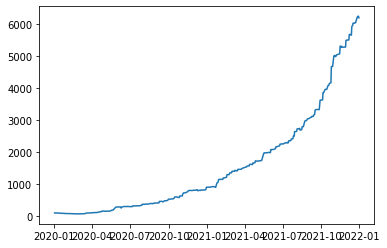

In [63]:
plt.plot(pivoted["date"],pivoted["pv"])